In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# pd.options.mode.chained_assignment = None  # default='warn'

<h2>Getting stock data</h2>

In [2]:
def make_stock_df(symbol):
    tickerData = yf.Ticker(symbol)
    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start='2010-1-1')
    dow = tickerDf.index.day_of_week
    data = tickerDf[["Close", "Volume"]]
    data.insert(1, 'Date_Week', dow)
    return data

In [3]:
def get_yahoo_stock_data(symbol, columns=None, dfrom='2020-1-1'):
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period='1d', start='2010-1-1')
    tickerDf["Date_Week"] = tickerDf.index.day_of_week
    targetDf = tickerDf if columns is None else tickerDf[columns]
    return targetDf

In [4]:
# ["Date_Week", "Open", "High", "Low", "Close", "Volume"]
TSM_df = get_yahoo_stock_data("TSM", columns=None, dfrom='2010-1-1')
TSM_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date_Week
Date,,,,,,,,
2010-01-04 00:00:00-05:00,7.586670,7.718727,7.573465,7.646096,8096400,0.0,0,0
2010-01-05 00:00:00-05:00,7.659300,7.698917,7.566860,7.613080,14375900,0.0,0,1
2010-01-06 00:00:00-05:00,7.632889,7.665903,7.514038,7.586669,13608400,0.0,0,2
2010-01-07 00:00:00-05:00,7.533848,7.553656,7.309351,7.335762,27346600,0.0,0,3
2010-01-08 00:00:00-05:00,7.355570,7.408393,7.282938,7.329159,16895300,0.0,0,4
...,...,...,...,...,...,...,...,...
2022-09-29 00:00:00-04:00,70.519997,70.680000,68.480003,69.279999,16120300,0.0,0,3
2022-09-30 00:00:00-04:00,67.809998,69.650002,67.739998,68.559998,10463200,0.0,0,4
2022-10-03 00:00:00-04:00,68.080002,69.570000,67.650002,69.250000,11945100,0.0,0,0


<AxesSubplot:xlabel='Date'>

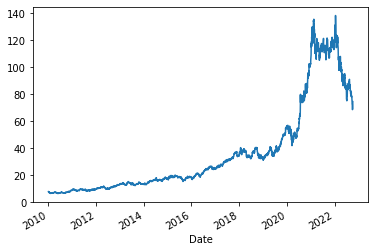

In [5]:
TSM_df.Close.plot()

In [29]:
TSM_df.iloc[2:]["Open"]

Date
2010-01-06 00:00:00-05:00     7.632889
2010-01-07 00:00:00-05:00     7.533848
2010-01-08 00:00:00-05:00     7.355570
2010-01-11 00:00:00-05:00     7.362173
2010-01-12 00:00:00-05:00     7.183897
                               ...    
2022-09-29 00:00:00-04:00    70.519997
2022-09-30 00:00:00-04:00    67.809998
2022-10-03 00:00:00-04:00    68.080002
2022-10-04 00:00:00-04:00    70.800003
2022-10-05 00:00:00-04:00    72.919998
Name: Open, Length: 3210, dtype: float64

In [85]:
def gen_features(data):
    # create a percentage change feature
    data['regress_y'] = data.Close.pct_change()

    # 2 days before features
    data['2d_before_close'] = 0
    data['2d_before_volume'] = 0

    # 1 day before features
    data['1d_before_close'] = 0
    data['1d_before_volume'] = 0    

    #data['2d_before_close'][2:] = data['Close'][:-2]   # With warning: A value is trying to be set on a copy of a slice from a DataFrame
    pd_2d_before_close = data['2d_before_close'].copy()
    pd_2d_before_close[2:] = data['Close'][:-2]
    data['2d_before_close'] = pd_2d_before_close

    #data['2d_before_volume'][2:] = data['Volume'][:-2]
    pd_2d_before_volume = data['2d_before_volume'].copy()
    pd_2d_before_volume[2:] = data['Volume'][:-2]
    data['2d_before_volume'] = pd_2d_before_volume

    #data['1d_before_close'][1:] = data['Close'][:-1]
    pd_1d_before_close = data['1d_before_close'].copy()
    pd_1d_before_close[1:] = data['Close'][:-1]
    data['1d_before_close'] = pd_1d_before_close
    
    #data['1d_before_volume'][1:] = data['Volume'][:-1]
    pd_1d_before_volume = data['1d_before_volume'].copy()
    pd_1d_before_volume[1:] = data['Volume'][:-1]
    data['1d_before_volume'] = pd_1d_before_volume

    data['f_price_change'] = data['1d_before_close'] - data['2d_before_close']

    data['f_volume_change'] = data['1d_before_volume'] - data['2d_before_volume']

    data['f_sign'] = np.sign(data['f_price_change'] * data['f_volume_change'])

    # data['f_date_week'] = data['Date_Week']

    data['f_volume_noise'] = data['1d_before_volume'] * data['2d_before_volume']
    data['f_price_noise'] = data['1d_before_close'] * data['2d_before_close']

    # scale data
    scaler = StandardScaler()
    data['f_price_change'] = scaler.fit_transform(np.array(data['f_price_change']).reshape(-1,1))    
    data['f_volume_change'] = scaler.fit_transform(np.array(data['f_volume_change']).reshape(-1,1))   
    data['f_volume_noise'] = scaler.fit_transform(np.array(data['f_volume_noise']).reshape(-1,1))   
    data['f_price_noise'] = scaler.fit_transform(np.array(data['f_price_noise']).reshape(-1,1))
    feature_pd = data.filter(regex='regress_y|f_*')[2:]         # first 2 record is missing 1d & 2d close and volume
    return feature_pd


In [86]:
gen_features(TSM_df)

Date
2010-01-04 00:00:00-05:00     0.000000
2010-01-05 00:00:00-05:00     0.000000
2010-01-06 00:00:00-05:00     7.646096
2010-01-07 00:00:00-05:00     7.613080
2010-01-08 00:00:00-05:00     7.586669
                               ...    
2022-09-29 00:00:00-04:00    73.029999
2022-09-30 00:00:00-04:00    72.129997
2022-10-03 00:00:00-04:00    69.279999
2022-10-04 00:00:00-04:00    68.559998
2022-10-05 00:00:00-04:00    69.250000
Name: 2d_before_close, Length: 3212, dtype: float64


,regress_y,2d_before_close,2d_before_volume,1d_before_close,1d_before_volume,f_price_change,f_volume_change,f_sign,f_volume_noise,f_price_noise
Date,,,,,,,,,,
2010-01-06 00:00:00-05:00,-0.003469,7.646096,8096400,7.613080,14375900,-0.051314,1.428962,-1.0,-0.030435,-0.568539
2010-01-07 00:00:00-05:00,-0.033072,7.613080,14375900,7.586669,13608400,-0.045227,-0.175838,1.0,0.591870,-0.568648
2010-01-08 00:00:00-05:00,-0.000900,7.586669,13608400,7.335762,27346600,-0.252106,3.127516,-1.0,1.978084,-0.569155
2010-01-11 00:00:00-05:00,-0.005405,7.335762,27346600,7.329159,16895300,-0.026974,-2.381110,1.0,2.683994,-0.569611
2010-01-12 00:00:00-05:00,-0.030797,7.329159,16895300,7.289542,22214500,-0.057397,1.210274,-1.0,2.003035,-0.569692
...,...,...,...,...,...,...,...,...,...,...
2022-09-29 00:00:00-04:00,-0.039512,73.029999,12430600,72.129997,12943600,-0.850261,0.115768,-1.0,0.319071,0.687420
2022-09-30 00:00:00-04:00,-0.010393,72.129997,12943600,69.279999,16120300,-2.647229,0.722367,-1.0,0.694136,0.622208
2022-10-03 00:00:00-04:00,0.010064,69.279999,16120300,68.559998,10463200,-0.684387,-1.289336,1.0,0.380118,0.562578
